Todo for next session:
- Comentarii la cod, structura lui, main parts ca si headers cum e acum: 1., 2. dar mai in detaliu
- Implementat algoritmul din paper in cadrul unei operatii de convolutie custom 
- Facem si partea de img fusion sau ramanem la segmentare pe baza focus??
- Metoda obiectiva de avaluare a rezultatelor: cautat metrici pentru a masura asta

Nice to have:
- Scriem functiile in module, si in jupyter doar le importam si exemplificam ce fac
- Raport tehnic, + update la ppt

In [9]:
# !./load_data.sh

## 1. Load images and process color channels

In [10]:
from pathlib import Path
import os
import cv2
import numpy as np

import matplotlib.pyplot as plt

In [11]:
DATA_PATH = Path.cwd() / 'data' 
DATA_PATH.as_posix()

'/home/astanea/code/image_processing/Image-Processing/data'

In [12]:
def get_random_img_path(data_path):
    return data_path / np.random.choice(os.listdir(data_path))

In [13]:
def get_images(path: str) -> np.ndarray:
    images = []
    for img in Path(path).glob('*.jpg'):
        img = cv2.imread(str(img))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
    return np.array(images)   

images = get_images(get_random_img_path(DATA_PATH).as_posix())
len(images)

2

In [14]:
def plot_images(images: np.ndarray):
    """Takes a list of images and plots them in a row, inside the same figure

    Args:
        images (np.ndarray): list containing images to be plotted as numpy arrays
    """
    num_images = len(images)
    cols = int(np.ceil(np.sqrt(num_images)))
    rows = int(np.ceil(num_images / cols))
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

    # If there's only one row and one column, axes is not an array
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])

    # If there's only one row, axes is a 1D array
    elif rows == 1:
        axes = np.array([axes])

    for ax, img in zip(axes.ravel(), images):
        ax.imshow(img, cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

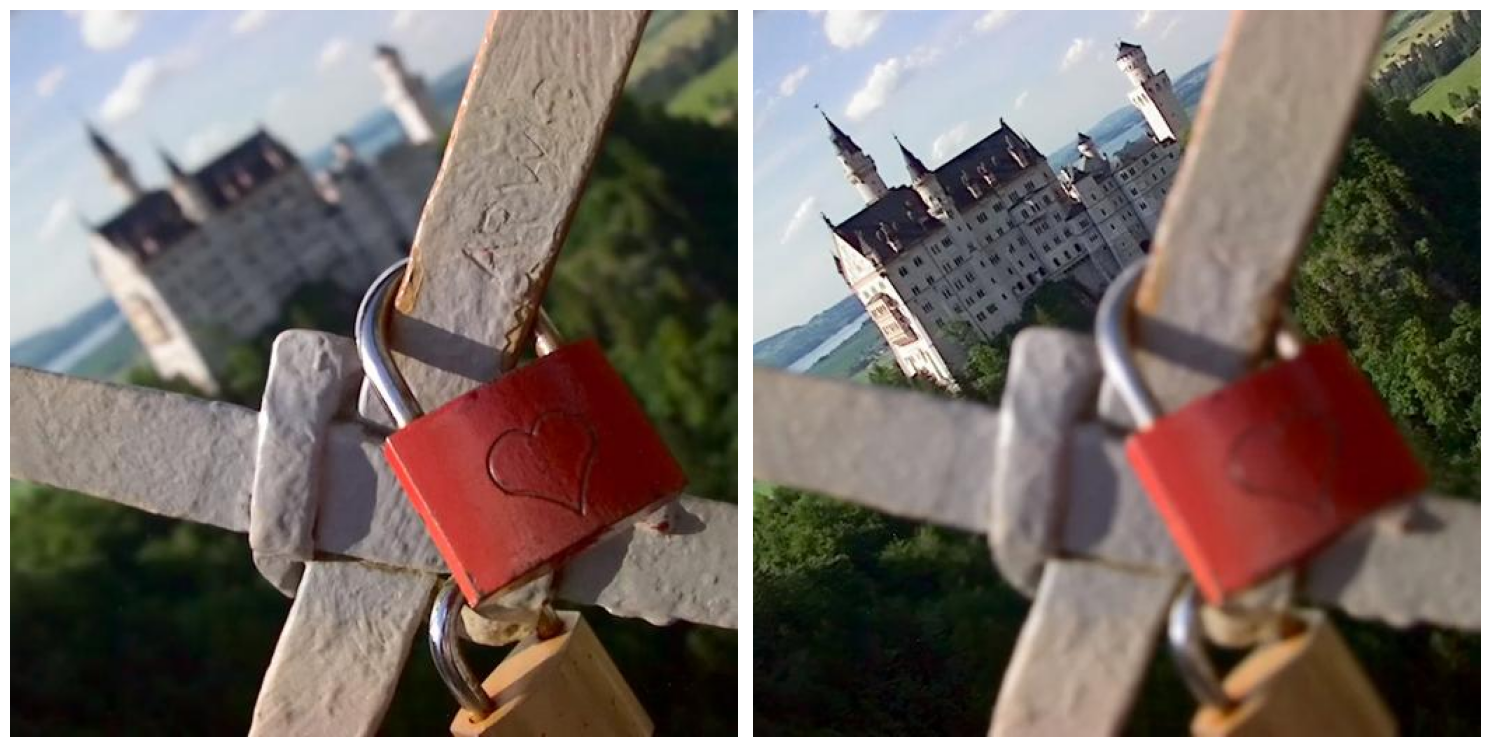

In [15]:
plot_images(images)

## 2. Implement convolution operation

- Create basic kernels
- Apply them using convolution operator into the loaded images
- 

In [16]:
class InvalidKernel(Exception):
    def __init__(self, message="Invalid kernel type"):
        self.message = message
        super().__init__(message)


class KernelFactory:
    @staticmethod
    def get_kernel(kernel_type):
        kernel = None
        if kernel_type == "edge_detection":
            kernel = np.array([[-1, -1, -1],
                               [-1,  8, -1],
                               [-1, -1, -1]],)
            
        if kernel_type == None:
            raise InvalidKernel()
        
        return kernel

In [17]:
kernel = KernelFactory.get_kernel("edge_detection")
kernel

array([[-1, -1, -1],
       [-1,  8, -1],
       [-1, -1, -1]])

References: 
- https://medium.com/@sabribarac/implementing-image-processing-kernels-from-scratch-using-convolution-in-python-4e966e9aafaf

In [20]:
def pad_image(img, padding):
    """Pads an image with zeros, given a padding size

    Args:
        img (np.ndarray): image to be padded
        padding (int): padding size

    Returns:
        np.ndarray: padded image
    """
    x_img_shape, y_img_shape, color_chn = img.shape[0], img.shape[1], img.shape[2]
    
    img_padded = np.zeros((x_img_shape + padding * 2, y_img_shape + padding * 2, color_chn)) 
    img_padded[padding:-padding, padding:-padding, :] = img
    return img_padded

In [21]:
def convolve2D(img: np.ndarray, kernel: np.ndarray, padding: int = 0, verbose=False):
    (R, G, B) = range(3)
    
    # Apply padding to all sides of the image if padding is not 0
    if padding != 0:
        img_padded = pad_image(img, padding)
    else:
        # not adding padding will result in a smaller output image
        img_padded = img
    
    out_img = np.zeros(img_padded.shape)
    
    height_img, width_img, color_chn = img_padded.shape
    height_kernel, width_kernel = kernel.shape
    
    # Create a new image of original img size minus the border
    # where the convolution can't be applied
    new_img = np.zeros((height_img - height_kernel + 1, width_img - width_kernel + 1, color_chn))
    
    if verbose:
        print(f"kernel_shape: {kernel.shape}")
        print(f"out_img shape: {out_img.shape}")
        print(f"new_img shape: {new_img.shape}")

    # Loop through each pixel in the image
    # But skip the outer edges of the image
    for y in range(height_kernel // 2, height_img - height_kernel // 2 - 1):
        for x in range(width_kernel // 2, width_img - width_kernel // 2 - 1):
            # Extract a window of pixels around the current pixel
            # TODO: implement in the window portion of the loop the SGML convolution formula
            window = img_padded[
                x - height_kernel // 2 : x + height_kernel // 2 + 1,
                y - width_kernel // 2 : y + width_kernel // 2 + 1,
            ]

            # Apply the convolution to the window and set the result as the value of the current pixel in the new image
            new_img[x, y, 0] = int((window[:, :, R] * kernel).sum())
            new_img[x, y, 1] = int((window[:, :, G] * kernel).sum())
            new_img[x, y, 2] = int((window[:, :, B] * kernel).sum())

    # Clip values to the range 0-255
    new_img = np.clip(new_img, 0, 255)
    return new_img.astype(np.uint8)

In [22]:
img1, img2 = images[0], images[1]
img1.shape, img2.shape

((520, 520, 3), (520, 520, 3))

In [23]:
img1_padded = pad_image(img1, 2)

In [25]:
padding = 1

img1_convolved = convolve2D(img1, kernel, padding=1)
img2_convolved = convolve2D(img2, kernel)

In [ ]:
img1_convolved.shape, img2_convolved.shape

NameError: name 'img1_convolved' is not defined

In [ ]:
plot_images([img1, img1_convolved])

NameError: name 'img1_convolved' is not defined

## Algorithm implementation

## Sum of the Gaussian-based modified Laplacian

TODO: describe what a kernel is, gaussian distribution and the visualizations below
TODO: add .ini file with hyperparameters

In [32]:
# OFFICIAL CV2 IMPLEMENTATION
kernel_size = 7
sigma = 2 
gaussian_kernel_1D = cv2.getGaussianKernel(kernel_size, sigma)
gaussian_kernel_2d = np.outer(gaussian_kernel_1D, gaussian_kernel_1D.transpose())

print(f"gaussian_kernel_1D shape: {gaussian_kernel_1D.shape}")
print(f"gaussian_kernel_2d shape: {gaussian_kernel_2d.shape}")

gaussian_kernel_1D shape: (7, 1)
gaussian_kernel_2d shape: (7, 7)


In [33]:
def plot_kernel_1D(kernel):
    plt.figure()
    plt.plot(kernel)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Representation of 1D Kernel')
    plt.show()
    
def plot_kernel_2D(kernel):
    # Create the x and y coordinate arrays
    x = np.arange(kernel.shape[0])
    y = np.arange(kernel.shape[1])
    x, y = np.meshgrid(x, y)

    # Create the figure
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    ax.plot_surface(x, y, kernel, cmap='viridis')

    # Labels and title
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Kernel Value')
    ax.set_title('3D Representation of 2D Kernel')

    # Show the plot
    plt.show()    

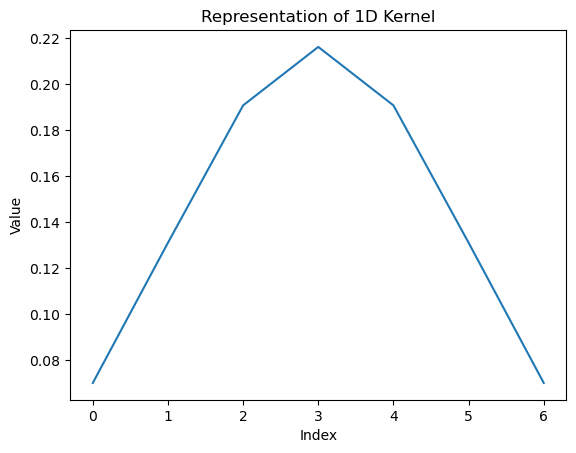

In [31]:
plot_kernel_1D(gaussian_kernel_1D)

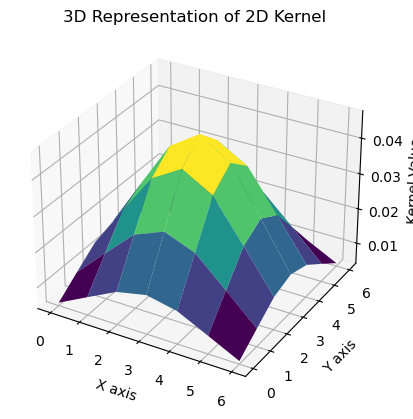

In [29]:
plot_kernel_2D(gaussian_kernel_2d)

In [ ]:
def ML(img, s=1):
    
    pass

In [ ]:
def SGML(img=None, sigma=2, kernel_size=7):
    """Applies the Sum of the Gaussian-based modified Laplacian (SGML) filter to the input image

    Args:
        img (np.ndarray): image to be filtered
        sigma (int, optional): standard deviation of the Gaussian Kernel. Defaults to 2.
        r (int, optional): kernel size. Defaults to 7.

    Returns:
        np.ndarray: filtered image
    """
    assert kernel_size%2 == 1 and kernel_size > 1, "kernel_size must be an odd number greater than 1"
    assert sigma > 0, "sigma must be greater than 0"
    

# Paper implementation of algorithm: image focus score

## References:
- https://github.com/OmarMSaad/1D-Modified-Laplacian-of-Gaussian-Filter-for-Smoothing-and-Denoising-/tree/master